<a href="https://colab.research.google.com/github/AndresPerelmuter/Clustering/blob/main/Cluster_H%26M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Segmentación de Clientes**
---

1 - Objetivo.

2 - Compresión de los datos.

3 - Preparación de los datos.


*   Limpieza
*   Construccion de nuevos datos.


4 - Modelado.

5 - Conclusión.

## **1 - Objetivo**


El objetivo de este trabajo es obtener un mejor conocimiento de los clientes con el proposito de llegarles de mejor manera y tomar mejores decisiones.

Los datos que se utilizaron en este projecto fueron obtenidos de la plataforma Kaggle (https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/overview).





## **2 - Comprensión de los Datos**

---




Los datos corresponden a transacciones realizadas entre los meses de octubre, de los años 2018 y 2020 correspondientemente.

**Instalación y carga de librerias.**

In [1]:
! pip install pyclustertend
! pip install yellowbrick 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import iplot
import plotly.graph_objs as go

from sklearn.metrics import pairwise_distances_argmin_min
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.spatial.distance import pdist, cdist
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import warnings
warnings.filterwarnings("ignore")

random.seed( 10 )

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Funciones a utilizar.**

In [4]:
def val_nulos(df):
    s1 = df.isnull().sum().rename('Valores Nulos')
    return pd.DataFrame(s1)

In [56]:
#A efectos del analisis de outliers, se considera no eliminar los valores atipicos sino que tomar el percentil 0.1 o 0.9. 
#Se considero de esta manera con el objetivo de no eliminar información.
def outliers(df):
    for col in df.columns:
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            percentiles = df[col].quantile([0.1,0.90]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]

**Recopilación de Datos Iniciales**

In [6]:
transactions = pd.read_csv("/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/transactions_train.csv")
articles = pd.read_csv("/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/articles.csv")
customers = pd.read_csv("/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/customers.csv")

In [7]:
transactions.head(5)

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [8]:
transactions.shape

(31788324, 5)

In [9]:
customers.head(5)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [10]:
customers.shape

(1371980, 7)

In [11]:
articles.head(5)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [15]:
articles.shape

(105542, 25)

**Exploración de los Datos**







In [12]:
transactions.describe()

,article_id,price,sales_channel_id
count,3.178832e+07,3.178832e+07,3.178832e+07
mean,6.962272e+08,2.782927e-02,1.704028e+00
std,1.334480e+08,1.918113e-02,4.564786e-01
min,1.087750e+08,1.694915e-05,1.000000e+00
25%,6.328030e+08,1.581356e-02,1.000000e+00
50%,7.145820e+08,2.540678e-02,2.000000e+00
75%,7.865240e+08,3.388136e-02,2.000000e+00
max,9.562170e+08,5.915254e-01,2.000000e+00


In [13]:
transactions.dtypes

t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

**Analisis de Precios**

Se analiza la distribución de los precios en el total de las transacciones. visualizandose algunos outliers.

<AxesSubplot: ylabel='price'>

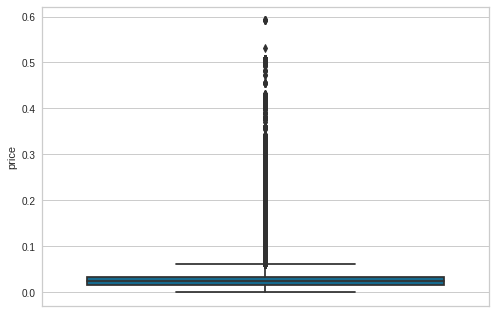

In [14]:
sns.boxplot(y = transactions['price'])

<AxesSubplot: xlabel='price', ylabel='Count'>

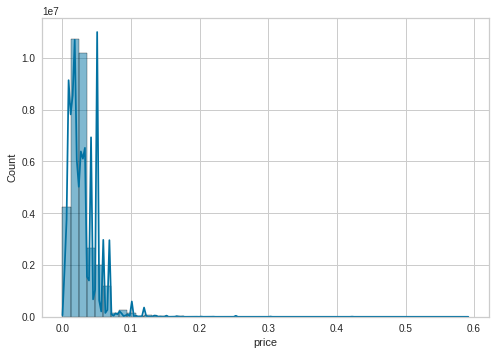

In [16]:
sns.histplot(data=transactions, x="price", palette='winter', bins=50, kde=True)

Se realiza un analisis de los precios promedio por articulo asi como su minimo y maximo.

In [19]:
preciopart = transactions.groupby('article_id', as_index=False).agg(
    Precio_Prom=('price', 'mean'),
    Min_Precio=('price', min),
    Max_Precio=('price', max))
preciopart

,article_id,Precio_Prom,Min_Precio,Max_Precio
0,108775015,0.008142,0.001339,0.009153
1,108775044,0.008114,0.001424,0.008508
2,108775051,0.004980,0.003237,0.008458
3,110065001,0.020219,0.002525,0.025407
4,110065002,0.018205,0.004542,0.025407
...,...,...,...,...
104542,952267001,0.014982,0.010153,0.016932
104543,952938001,0.048006,0.040661,0.050831
104544,953450001,0.016836,0.015305,0.016932
104545,953763001,0.021908,0.021169,0.022017


En el cuadro debajo, se visualiza la cantidad de transacciones agrupada por día y cliente. Aqui se ven valores atipicos como la compra de 540 articulos en una transacción. En siguientes puntos se tratara este tema como outliers.

In [20]:
#Se crea un numero de transaccion para poder evaluar las transacciones y analizar posibles errores en ellas. 
transactions['n_trans'] = transactions['t_dat'] + transactions['customer_id']
trans_dia = transactions.groupby(['n_trans'], as_index=False).agg(Cantidad=('article_id', 'count')).sort_values(by=['Cantidad'], ascending=False)

In [21]:
trans_dia.sort_values(by=['Cantidad'], ascending=False)

,n_trans,Cantidad
330656,2018-10-14d00063b94dcb1342869d4994844a2742b5d6...,570
1161741,2018-12-17c2f0cdda2dc3042ccd9fcd8253fd8e368769...,336
1489900,2019-01-1362fd7d41b587c72a95c31eca5046019ce4e8...,221
333665,2018-10-15246734d8f4a4252fcd5c7aa525055a2804b9...,220
1869380,2019-02-1694665b46e194622ccdbcadc0170f13a2f8ed...,199
...,...,...
3097103,2019-05-2594a8ecbdfa06b79cad5dabf17f589dd3e343...,1
3097104,2019-05-2594abfdb4008c6694f0c81364300e970952db...,1
3097106,2019-05-2594b43cb3410386158516c9ade1bd05912d2e...,1
3097109,2019-05-2594bf4585813a3b38a52d7bfdefdc52b705b5...,1


En el siguiente diagrama, se observan outliers en las transacciones. Estas se miden a partir de la cantidad de articulos comprados cada dia por cada cliente.

<AxesSubplot: xlabel='Cantidad'>

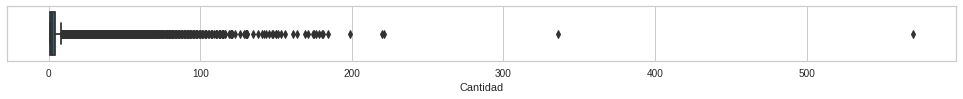

In [22]:
plt.figure(figsize=(17,1))
sns.boxplot(x = trans_dia['Cantidad'])

In [23]:
customers.describe()

,FN,Active,age
count,476930.0,464404.0,1.356119e+06
mean,1.0,1.0,3.638696e+01
std,0.0,0.0,1.431363e+01
min,1.0,1.0,1.600000e+01
25%,1.0,1.0,2.400000e+01
50%,1.0,1.0,3.200000e+01
75%,1.0,1.0,4.900000e+01
max,1.0,1.0,9.900000e+01


In [24]:
customers.dtypes

customer_id                object
FN                        float64
Active                    float64
club_member_status         object
fashion_news_frequency     object
age                       float64
postal_code                object
dtype: object

<AxesSubplot: ylabel='age'>

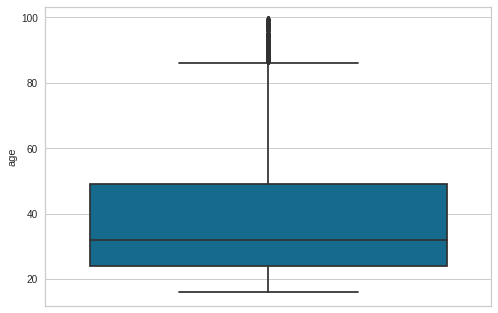

In [25]:
sns.boxplot(y = customers['age'])

Se observa una gran cantidad de clientes entre los 20 y 40 años, disminuyendo de alli en adelante.

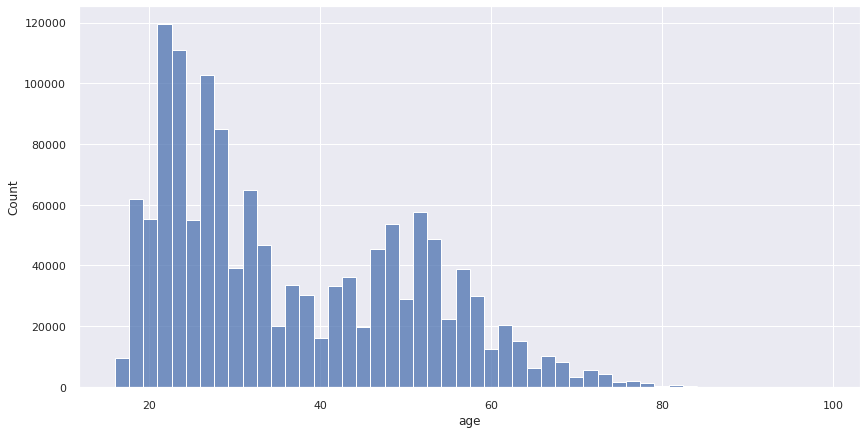

In [26]:
plt.figure(figsize=(14, 7))

sns.set(style="darkgrid")

sns.histplot(data=customers, x="age", bins=50)
plt.show()

In [27]:
articles.describe()

,article_id,product_code,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_group_no,section_no,garment_group_no
count,1.055420e+05,105542.000000,105542.000000,1.055420e+05,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000
mean,6.984246e+08,698424.563378,234.861875,1.009515e+06,32.233822,3.206183,7.807972,4532.777833,3.171534,42.664219,1010.438290
std,1.284624e+08,128462.384432,75.049308,2.241359e+04,28.086154,1.563839,5.376727,2712.692011,4.353234,23.260105,6.731023
min,1.087750e+08,108775.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,1201.000000,1.000000,2.000000,1001.000000
25%,6.169925e+08,616992.500000,252.000000,1.010008e+06,9.000000,2.000000,4.000000,1676.000000,1.000000,20.000000,1005.000000
50%,7.022130e+08,702213.000000,259.000000,1.010016e+06,14.000000,4.000000,5.000000,4222.000000,2.000000,46.000000,1009.000000
75%,7.967030e+08,796703.000000,272.000000,1.010016e+06,52.000000,4.000000,11.000000,7389.000000,4.000000,61.000000,1017.000000
max,9.594610e+08,959461.000000,762.000000,1.010029e+06,93.000000,7.000000,20.000000,9989.000000,26.000000,97.000000,1025.000000


In [28]:
articles.dtypes

article_id                       int64
product_code                     int64
prod_name                       object
product_type_no                  int64
product_type_name               object
product_group_name              object
graphical_appearance_no          int64
graphical_appearance_name       object
colour_group_code                int64
colour_group_name               object
perceived_colour_value_id        int64
perceived_colour_value_name     object
perceived_colour_master_id       int64
perceived_colour_master_name    object
department_no                    int64
department_name                 object
index_code                      object
index_name                      object
index_group_no                   int64
index_group_name                object
section_no                       int64
section_name                    object
garment_group_no                 int64
garment_group_name              object
detail_desc                     object
dtype: object

In [29]:
art = articles.groupby('index_group_name', as_index=False).agg(Cantidad=('article_id', 'count')).sort_values(by=['Cantidad'], ascending=False)
art

,index_group_name,Cantidad
2,Ladieswear,39737
0,Baby/Children,34711
1,Divided,15149
3,Menswear,12553
4,Sport,3392


### **Preparación de los Datos**

---



**Limpieza de Datos**

In [30]:
val_nulos(transactions)

,Valores Nulos
t_dat,0
customer_id,0
article_id,0
price,0
sales_channel_id,0
n_trans,0


In [31]:
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

Se evaluan los outliers en las precios de las transacciones. Se modifican aquellos valores que son considerados outliers, tomando el percentil 0.1 o 0.9.

In [32]:
outliers(transactions)

En este caso, se analizo la cantidad de articulos comprados por cada cliente en el mismo dia. A partir de este valor, se analizo posiles outliers.

Para el caso de los outliers, se tomo el valor percentil 0.1 y 0.9 sin eliminar la transaccion por completo, ya que al no tener mayor información no era posible considerarla como un posible fraude. 

In [33]:
outliers(trans_dia)

In [34]:
n_trans = trans_dia['n_trans'].tolist()

transactions = transactions[(transactions['n_trans'].isin(n_trans))]

In [35]:
val_nulos(customers)

,Valores Nulos
customer_id,0
FN,895050
Active,907576
club_member_status,6062
fashion_news_frequency,16009
age,15861
postal_code,0


In [36]:
customers['age']=customers['age'].fillna(customers['age'].mean())

In [37]:
customers['age'] = customers['age'].astype(np.int64)

In [38]:
val_nulos(articles)

,Valores Nulos
article_id,0
product_code,0
prod_name,0
product_type_no,0
product_type_name,0
product_group_name,0
graphical_appearance_no,0
graphical_appearance_name,0
colour_group_code,0
colour_group_name,0


In [39]:
aux1 = pd.merge(transactions[["customer_id", 'price', "sales_channel_id"]], customers[["customer_id",'age']])
aux1 = pd.DataFrame(aux1.groupby(['age', "sales_channel_id"], as_index=False).agg(ventas=('price', sum)))

# Create new dataframe column with the labels instead of numbers
aux1["sales_channel_id"] = aux1['sales_channel_id'].replace([1, 2], ['Store', 'Online'])
aux1.rename(columns={"sales_channel_id": "Canal Venta"}, inplace = True)
aux1['age'] = aux1['age'].astype('Int64', errors='ignore' )
aux1 = aux1[aux1.age < 70]

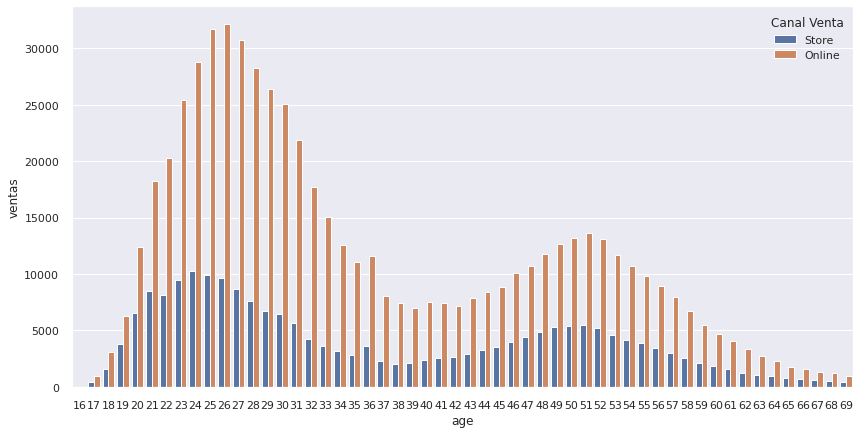

In [40]:
plt.figure(figsize=(14, 7))

bar1 = sns.barplot(x="age",  y="ventas", hue = 'Canal Venta', data=aux1, saturation=0.75, errcolor='.26')

plt.show()

In [43]:
aux2 = pd.merge(transactions[["article_id", 'price']], articles[["article_id",'index_group_name']])
aux2 = aux2.groupby('index_group_name', as_index=False).agg(ventas=('price', sum))

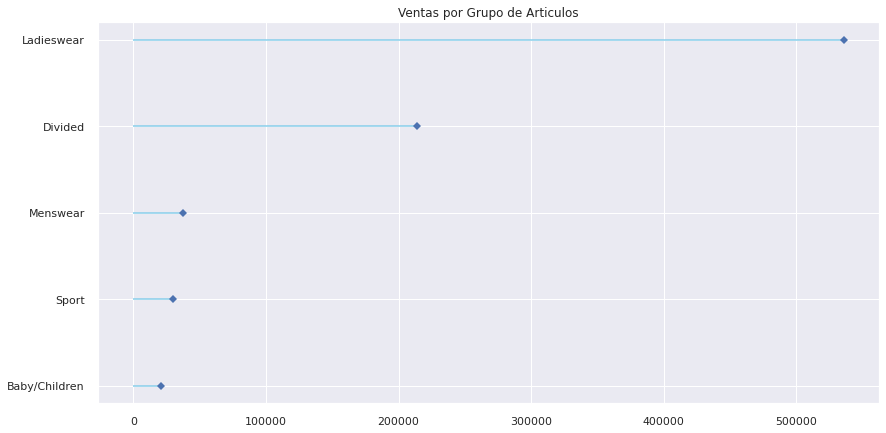

In [44]:
# Reorder it based on the values:
fig, ax = plt.subplots(figsize=(14,7))
ordered_df = aux2.sort_values(by='ventas')
my_range=range(1,len(aux2.index)+1)
 
# Horizontal version
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['ventas'], color='skyblue')
plt.plot(ordered_df['ventas'], my_range, "D")
plt.yticks(my_range, ordered_df['index_group_name'])
plt.title("Ventas por Grupo de Articulos")
plt.show()

In [45]:
aux3 = transactions.groupby(['t_dat', 'sales_channel_id'], as_index=False).agg(ventas=('price', sum))

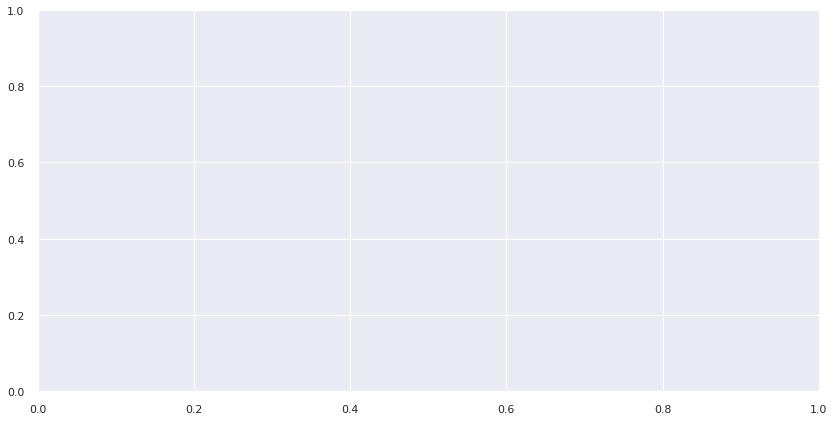

In [100]:
aux3["sales_channel_id"] = aux3['sales_channel_id'].replace([1, 2], ['Store', 'Online'])
fig, ax = plt.subplots(figsize=(14,7))

Text(0.5, 1.0, 'Evolución de Ventas')

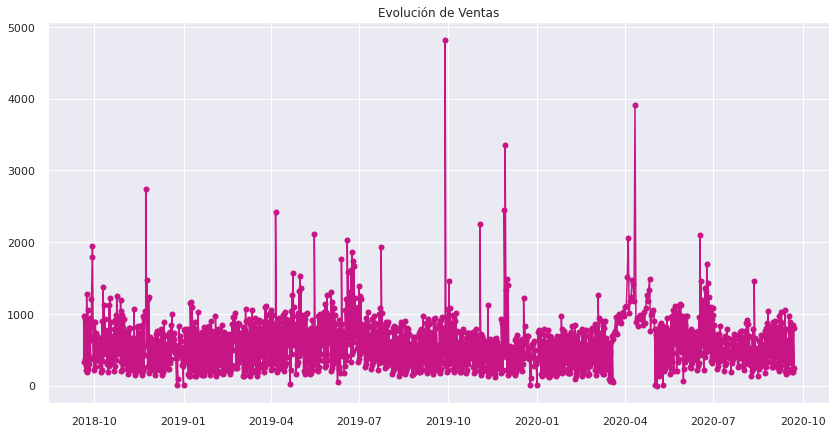

In [46]:
fig, ax = plt.subplots(figsize=(14,7))
plt.plot( 't_dat', 'ventas', data=aux3, marker='o', color='mediumvioletred')
plt.title("Evolución de Ventas")

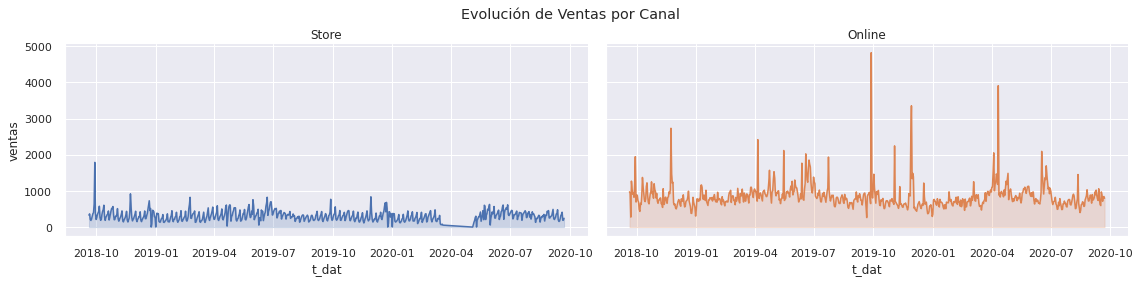

In [99]:
# Create a grid : initialize it
g = sns.FacetGrid(aux3, col='sales_channel_id', hue='sales_channel_id', col_wrap=2, height=4, aspect=2)

# Add the line over the area with the plot function
g = g.map(plt.plot, 't_dat', 'ventas')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 't_dat', 'ventas', alpha=0.2).set_titles("{col_name} Cluster")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plot
plt.subplots_adjust(top=0.85)
g = g.fig.suptitle('Evolución de Ventas por Canal')

# Show the graph
plt.show()

In [48]:
ventaspdia= transactions.groupby(['t_dat'], as_index=False).agg(ventas=('price', sum))
ventaspdia.sort_values(by ='ventas', ascending=False).head(15)

,t_dat,ventas
373,2019-09-28,5590.482068
435,2019-11-29,4190.065746
569,2020-04-11,3909.540627
9,2018-09-29,3735.621390
64,2018-11-23,3651.079898
198,2019-04-06,3006.576254
434,2019-11-28,2868.127203
636,2020-06-17,2519.782780
238,2019-05-16,2495.327881
409,2019-11-03,2440.984203


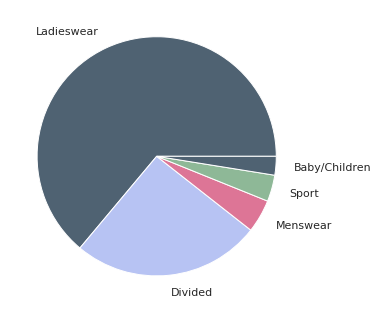

In [49]:
dfg = pd.merge(transactions[["article_id", 'price']], articles[['article_id','index_group_name']], on="article_id", how='inner')
dfg = dfg.groupby('index_group_name', as_index=False).agg(ventas=('price', sum))
dfg = dfg.sort_values(by = 'ventas', ascending=False).head(15)

# Create a set of colors
colors = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']

# Use it thanks to the color argument
plt.pie(dfg.ventas, labels=dfg.index_group_name, labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors);

In [53]:
dfm = pd.merge(transactions[["article_id", 'price']], articles[['article_id','index_group_name', 'section_name']], on="article_id", how='inner')
dfm = dfm.groupby('section_name', as_index=False).agg(ventas=('price', sum))
dfm = dfm.sort_values(by = 'ventas', ascending=False).head(15)

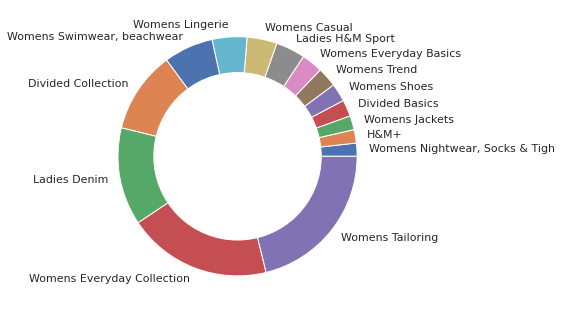

In [52]:
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

# Not enough colors --> colors will cycle
plt.pie(dfm["ventas"], labels=dfm["section_name"])
p = plt.gcf()
p.gca().add_artist(my_circle)

# Show the graph
plt.show()

**Construcción de Datos**

In [54]:
df = transactions.groupby('customer_id').agg(
    precio_promedio=('price', 'mean'),
    compras_totales=('price', sum),
    cantidad_compras=('t_dat', 'nunique')
)

In [55]:
df['promedio_dias_compra'] = transactions['previous_visit'] = transactions.groupby(['customer_id'])['t_dat'].shift()
df['promedio_dias_compra'] = transactions['days_bw_visits'] = transactions['t_dat'] - transactions['previous_visit']
df['promedio_dias_compra'] = transactions['days_bw_visits'] = transactions['days_bw_visits'].apply(lambda x: x.days)
df['promedio_dias_compra'] = transactions.groupby('customer_id')['days_bw_visits'].agg('mean')

df = pd.merge(df, customers[['customer_id','age']], on="customer_id", how = 'left')
df.fillna(axis=1, method="bfill").fillna(0)


,customer_id,precio_promedio,compras_totales,cantidad_compras,promedio_dias_compra,age
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.030581,0.642203,10,30.900000,49
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.028676,2.466136,23,7.717647,25
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.036235,0.652237,7,42.705882,24
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.030492,0.060983,1,0.000000,54
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0.035478,0.461220,6,55.833333,52
...,...,...,...,...,...,...
1362276,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0.025171,1.283729,11,10.440000,24
1362277,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0.021321,1.790949,19,8.349398,21
1362278,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0.018214,0.819627,19,16.363636,21
1362279,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0.029886,0.209203,4,13.000000,18


In [57]:
df6 = transactions[['customer_id','sales_channel_id']]
df6["sales_channel_id"] = df6['sales_channel_id'].replace([1, 2], ['Store', 'Online'])
df6 = df6.pivot_table(index='customer_id', columns='sales_channel_id', aggfunc=len, fill_value=0)

In [58]:
temp = pd.merge(transactions[["customer_id", "article_id"]], articles[['article_id','index_group_name']], on="article_id", how='inner')
temp = temp.dropna()
ca_matrix = pd.crosstab(index=temp.customer_id, columns=temp.index_group_name)
ca_matrix = pd.DataFrame(ca_matrix)

In [59]:
df8 = pd.merge(ca_matrix, df, on='customer_id')
df8 = pd.merge(df8, df6, on='customer_id')
df8


,customer_id,Baby/Children,Divided,Ladieswear,Menswear,Sport,precio_promedio,compras_totales,cantidad_compras,promedio_dias_compra,age,Online,Store
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,5,2,14,0,0,0.030581,0.642203,10,30.900000,49,12,9
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,4,23,59,0,0,0.028676,2.466136,23,7.717647,25,81,5
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,2,13,2,1,0.036235,0.652237,7,42.705882,24,18,0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,0,0,2,0.030492,0.060983,1,0.000000,54,2,0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0,2,9,0,2,0.035478,0.461220,6,55.833333,52,11,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1362276,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0,2,44,1,4,0.025171,1.283729,11,10.440000,24,38,13
1362277,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,7,46,29,2,0,0.021321,1.790949,19,8.349398,21,56,28
1362278,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0,24,16,4,1,0.018214,0.819627,19,16.363636,21,34,11
1362279,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0,2,5,0,0,0.029886,0.209203,4,13.000000,18,6,1


In [60]:
df8['cantidad_compras'].mean()

6.6654229193536425

In [63]:
# selecting numerical columns
num_cols = df8[['Baby/Children', 'Divided','Ladieswear', 'Menswear', 'Sport', 'precio_promedio', 'promedio_dias_compra', 'age', 'Online', 'Store']]
#num_cols = df8.select_dtypes(include=np.number).columns.tolist()

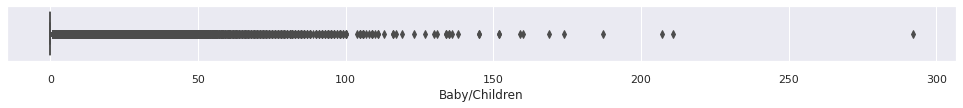

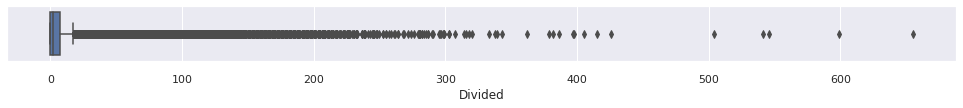

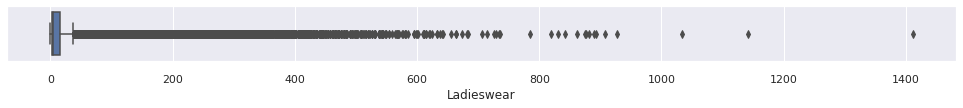

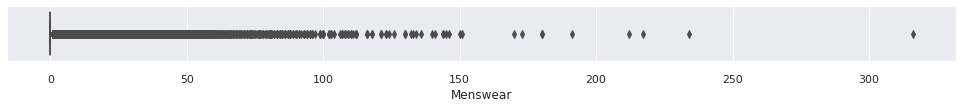

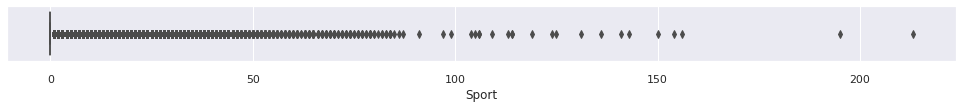

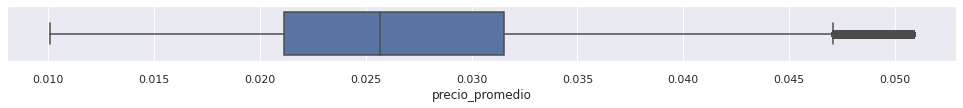

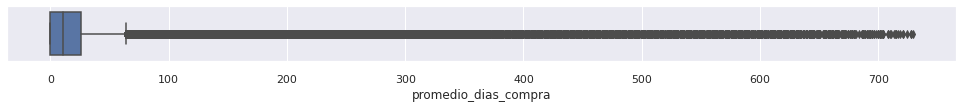

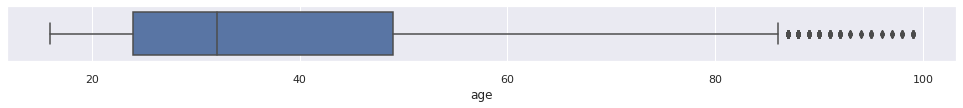

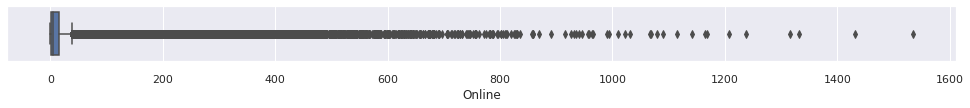

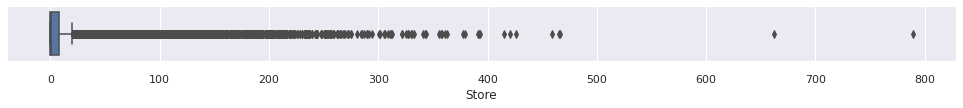

In [64]:
for column in num_cols:
        plt.figure(figsize=(17,1))
        sns.boxplot(data=num_cols, x=column)

In [ ]:
#sns.pairplot(num_cols,diag_kind="kde")

In [65]:
val_nulos(df8)

,Valores Nulos
customer_id,0
Baby/Children,0
Divided,0
Ladieswear,0
Menswear,0
Sport,0
precio_promedio,0
compras_totales,0
cantidad_compras,0
promedio_dias_compra,131514


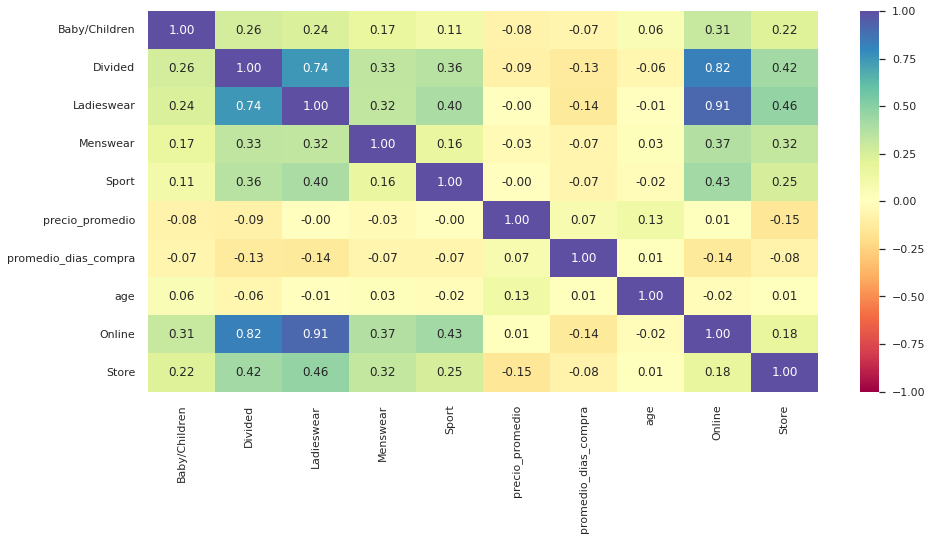

In [66]:
# check for correlations

plt.figure(figsize=(15, 7))
sns.heatmap(
    num_cols.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

# **Modelado**

---



In [67]:
dfcluster = num_cols
dfcluster = dfcluster.dropna()

In [68]:
scaler = StandardScaler()
dfcluster = scaler.fit_transform(dfcluster)

In [69]:
from pyclustertend import hopkins
hopkins(dfcluster,150)

0.003712644717502202

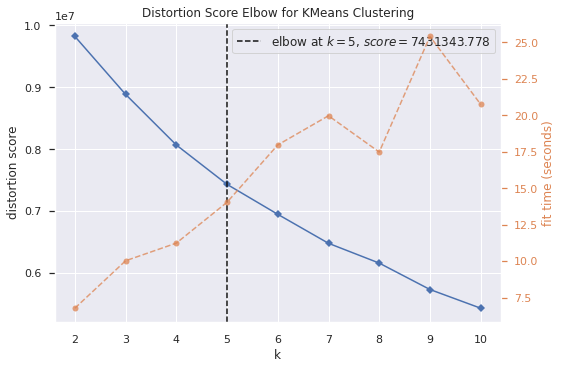

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [70]:
kmeanModel = KMeans()
elb_visualizer = KElbowVisualizer(kmeanModel, k=(2,11))
elb_visualizer.fit(dfcluster)    
elb_visualizer.show() 

In [71]:
# Para el ejercicio, elijo 5 como un buen valor de K. Pero podría ser otro.
kmeans = KMeans(n_clusters=6).fit(dfcluster)
predict=kmeans.predict(dfcluster)
#dfcluster['Pred'] = kmeans.predict

In [72]:
df8 = df8.dropna()
df8["Cluster"] = kmeans.labels_

In [74]:
results = df8.groupby(['Cluster'], as_index = False).agg(
    Cantidad=('customer_id', 'count'),    
    precio_promedio=('precio_promedio', 'mean'),
    compras_totales=('compras_totales', sum),    
    #antiguedad=('antiguedad', 'mean'),
    #min_antiguedad=('antiguedad', 'min'),
    #max_antiguedad=('antiguedad', 'max'),    
    promedio_dias_compras=('promedio_dias_compra', 'mean'),  
    age=('age', 'mean'),
    store=('Store', 'mean'),
    online=('Online', 'mean'),
    baby_children=('Baby/Children', 'mean'),
    Ladieswear	=('Ladieswear', 'mean'),  
    Menswear=('Menswear', 'mean'),
    Sport=('Sport', 'mean'),       
)

# **Conclusión**

---



In [75]:
results

,Cluster,Cantidad,precio_promedio,compras_totales,promedio_dias_compras,age,store,online,baby_children,Ladieswear,Menswear,Sport
0,0,498054,0.022458,173084.887712,18.766728,25.989286,5.207843,9.641681,0.368860,8.900091,0.556177,0.442291
1,1,158426,0.025761,325288.092254,9.004357,35.387525,25.951877,52.659759,2.405887,47.568915,4.208129,2.851622
2,2,21614,0.027595,138061.708949,3.269392,36.623392,24.250948,206.097853,8.346535,143.017581,9.783474,7.915101
3,3,32187,0.029725,3361.197576,196.674969,37.086122,1.264579,2.299313,0.103675,2.158325,0.134526,0.136422
4,4,308161,0.024331,113488.710458,19.303632,52.904212,5.823462,8.819497,0.837221,8.883256,0.697973,0.395323
5,5,212325,0.038115,80469.447966,16.900972,36.821985,1.453889,8.912102,0.190562,7.102249,0.380078,0.367606


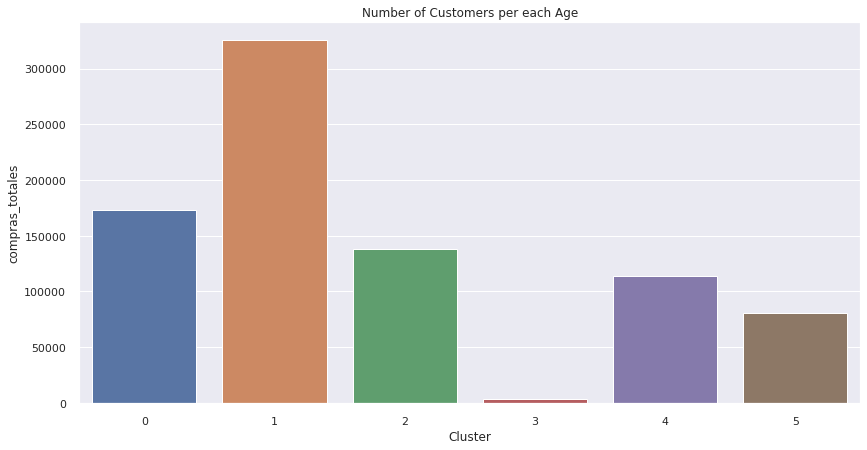

In [76]:
plt.figure(figsize = (14,7))
plt.title(f'Number of Customers per each Age')
sns.set_color_codes("pastel")
sns.barplot(x = 'Cluster', y="compras_totales", data=results)

plt.show()

In [79]:
aux5 = pd.merge(transactions[["customer_id", 't_dat', 'price' ]], df8[["customer_id",'Cluster']], on="customer_id", how='inner')
aux5 = aux5.groupby(['t_dat', 'Cluster'], as_index=False).agg(ventas=('price', sum))

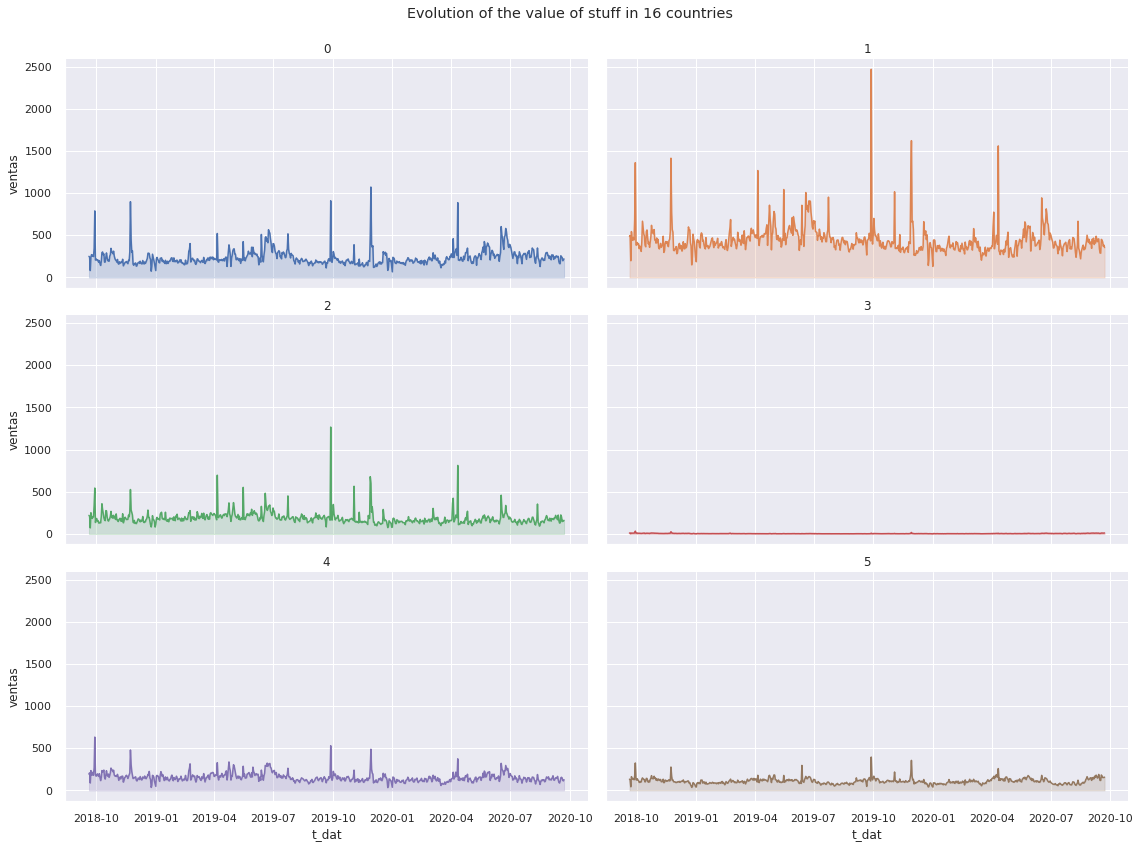

In [91]:
# Create a grid : initialize it
g = sns.FacetGrid(aux5, col='Cluster', hue='Cluster', col_wrap=2, height=4, aspect=2)

# Add the line over the area with the plot function
g = g.map(plt.plot, 't_dat', 'ventas')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 't_dat', 'ventas', alpha=0.2).set_titles("{col_name} Cluster")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plot
plt.subplots_adjust(top=0.92)
g = g.fig.suptitle('Evolution of the value of stuff in 16 countries')

# Show the graph
plt.show()

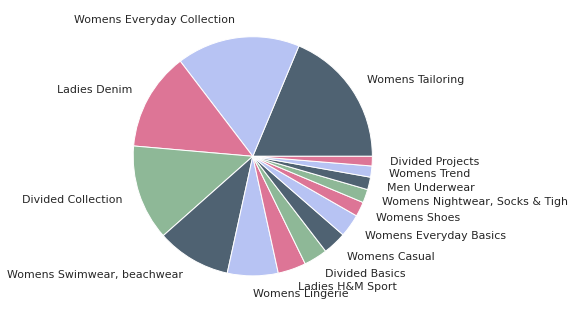

In [78]:
dfcluster0 = df8[df8['Cluster']==0]
dfcluster0 = pd.merge(dfcluster0[['customer_id', "Cluster"]], transactions[['customer_id','article_id', 'price']], on="customer_id", how='inner')

dfcluster0 = pd.merge(dfcluster0[['customer_id', "Cluster", 'article_id', 'price']], articles[['article_id','index_group_name', 'section_name']], on="article_id", how='inner')
dfcluster0 = dfcluster0.groupby('section_name', as_index=False).agg(ventas=('price', sum))
dfcluster0 = dfcluster0.sort_values(by = 'ventas', ascending=False).head(15)

# Create a set of colors
colors = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']

# Use it thanks to the color argument
plt.pie(dfcluster0.ventas, labels=dfcluster0.section_name, labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors);

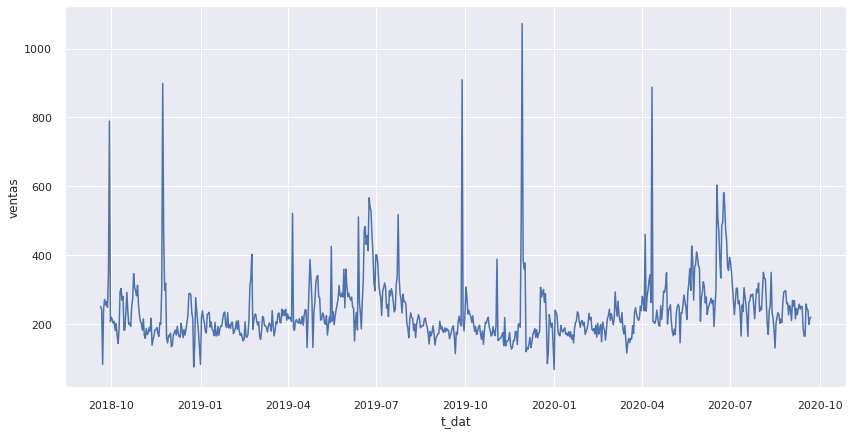

In [80]:
aux5cluster0 = aux5[aux5['Cluster']==0]
fig, ax = plt.subplots(figsize=(14,7))

# multiple line plots
sns.lineplot(data=aux5cluster0, x='t_dat', y='ventas')

# show graph
plt.show()

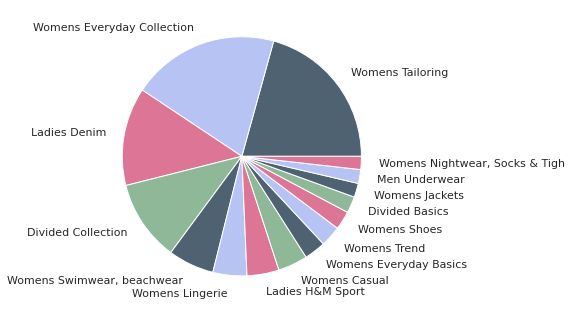

In [81]:
dfcluster1 = df8[df8['Cluster']==1]
dfcluster1 = pd.merge(dfcluster1[['customer_id', "Cluster"]], transactions[['customer_id','article_id', 'price']], on="customer_id", how='inner')

dfcluster1 = pd.merge(dfcluster1[['customer_id', "Cluster", 'article_id', 'price']], articles[['article_id','index_group_name', 'section_name']], on="article_id", how='inner')
dfcluster1 = dfcluster1.groupby('section_name', as_index=False).agg(ventas=('price', sum))
dfcluster1 = dfcluster1.sort_values(by = 'ventas', ascending=False).head(15)

# Create a set of colors
colors = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']

# Use it thanks to the color argument
plt.pie(dfcluster1.ventas, labels=dfcluster1.section_name, labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors);

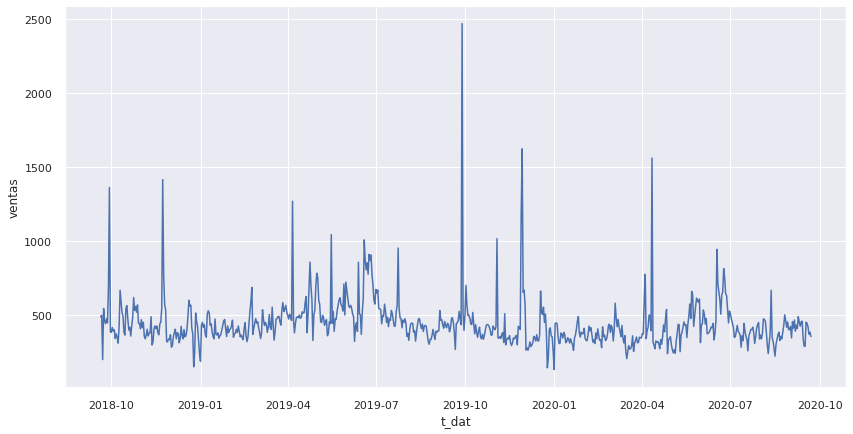

In [82]:
aux5cluster1 = aux5[aux5['Cluster']==1]
fig, ax = plt.subplots(figsize=(14,7))

# multiple line plots
sns.lineplot(data=aux5cluster1, x='t_dat', y='ventas')

# show graph
plt.show()

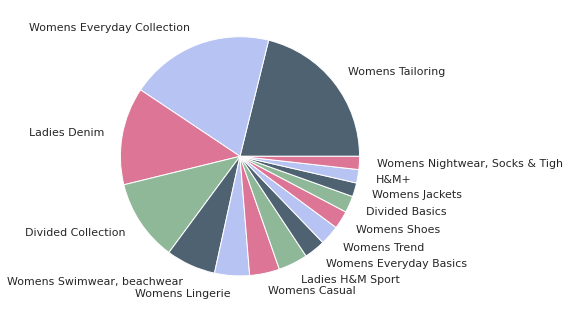

In [83]:
dfcluster2 = df8[df8['Cluster']==2]
dfcluster2 = pd.merge(df8[['customer_id', "Cluster"]], transactions[['customer_id','article_id', 'price']], on="customer_id", how='inner')

dfcluster2 = pd.merge(dfcluster2[['customer_id', "Cluster", 'article_id', 'price']], articles[['article_id','index_group_name', 'section_name']], on="article_id", how='inner')
dfcluster2 = dfcluster2.groupby('section_name', as_index=False).agg(ventas=('price', sum))
dfcluster2 = dfcluster2.sort_values(by = 'ventas', ascending=False).head(15)

# Create a set of colors
colors = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']

# Use it thanks to the color argument
plt.pie(dfcluster2.ventas, labels=dfcluster2.section_name, labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors);

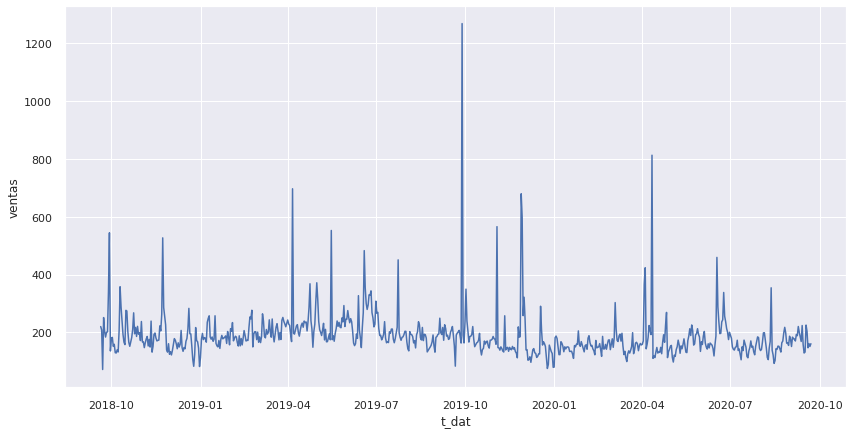

In [84]:
aux5cluster2 = aux5[aux5['Cluster']==2]
fig, ax = plt.subplots(figsize=(14,7))

# multiple line plots
sns.lineplot(data=aux5cluster2, x='t_dat', y='ventas')

# show graph
plt.show()

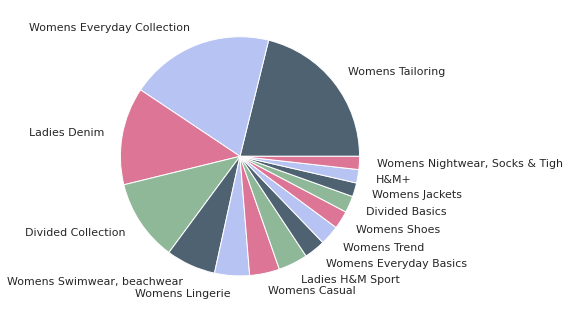

In [85]:
dfcluster3 = df8[df8['Cluster']==3]
dfcluster3 = pd.merge(df8[['customer_id', "Cluster"]], transactions[['customer_id','article_id', 'price']], on="customer_id", how='inner')

dfcluster3 = pd.merge(dfcluster3[['customer_id', "Cluster", 'article_id', 'price']], articles[['article_id','index_group_name', 'section_name']], on="article_id", how='inner')
dfcluster3 = dfcluster3.groupby('section_name', as_index=False).agg(ventas=('price', sum))
dfcluster3 = dfcluster3.sort_values(by = 'ventas', ascending=False).head(15)

# Create a set of colors
colors = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']

# Use it thanks to the color argument
plt.pie(dfcluster3.ventas, labels=dfcluster3.section_name, labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors);

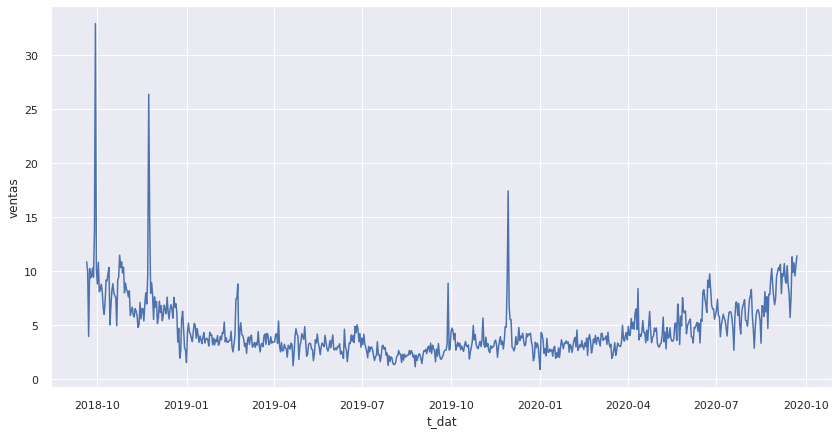

In [86]:
aux5cluster3 = aux5[aux5['Cluster']==3]
fig, ax = plt.subplots(figsize=(14,7))

# multiple line plots
sns.lineplot(data=aux5cluster3, x='t_dat', y='ventas')

# show graph
plt.show()

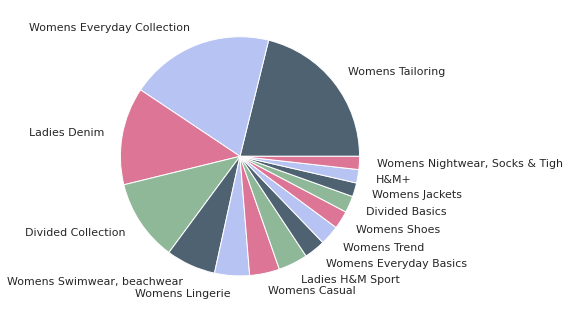

In [87]:
dfcluster4 = df8[df8['Cluster']==4]
dfcluster4 = pd.merge(df8[['customer_id', "Cluster"]], transactions[['customer_id','article_id', 'price']], on="customer_id", how='inner')

dfcluster4 = pd.merge(dfcluster4[['customer_id', "Cluster", 'article_id', 'price']], articles[['article_id','index_group_name', 'section_name']], on="article_id", how='inner')
dfcluster4 = dfcluster4.groupby('section_name', as_index=False).agg(ventas=('price', sum))
dfcluster4 = dfcluster4.sort_values(by = 'ventas', ascending=False).head(15)

# Create a set of colors
colors = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']

# Use it thanks to the color argument
plt.pie(dfcluster4.ventas, labels=dfcluster4.section_name, labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors);

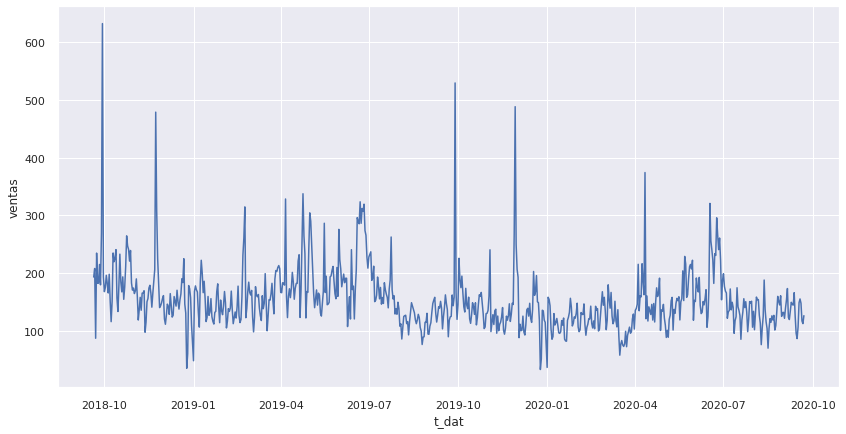

In [88]:
aux5cluster4 = aux5[aux5['Cluster']==4]
fig, ax = plt.subplots(figsize=(14,7))

# multiple line plots
sns.lineplot(data=aux5cluster4, x='t_dat', y='ventas')

# show graph
plt.show()

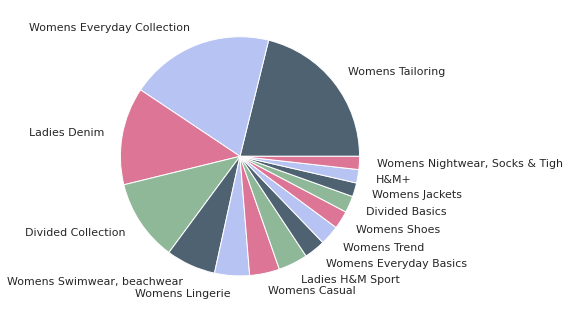

In [89]:
dfcluster5 = df8[df8['Cluster']==5]
dfcluster5 = pd.merge(df8[['customer_id', "Cluster"]], transactions[['customer_id','article_id', 'price']], on="customer_id", how='inner')

dfcluster5 = pd.merge(dfcluster5[['customer_id', "Cluster", 'article_id', 'price']], articles[['article_id','index_group_name', 'section_name']], on="article_id", how='inner')
dfcluster5 = dfcluster5.groupby('section_name', as_index=False).agg(ventas=('price', sum))
dfcluster5 = dfcluster5.sort_values(by = 'ventas', ascending=False).head(15)

# Create a set of colors
colors = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']

# Use it thanks to the color argument
plt.pie(dfcluster5.ventas, labels=dfcluster5.section_name, labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors);

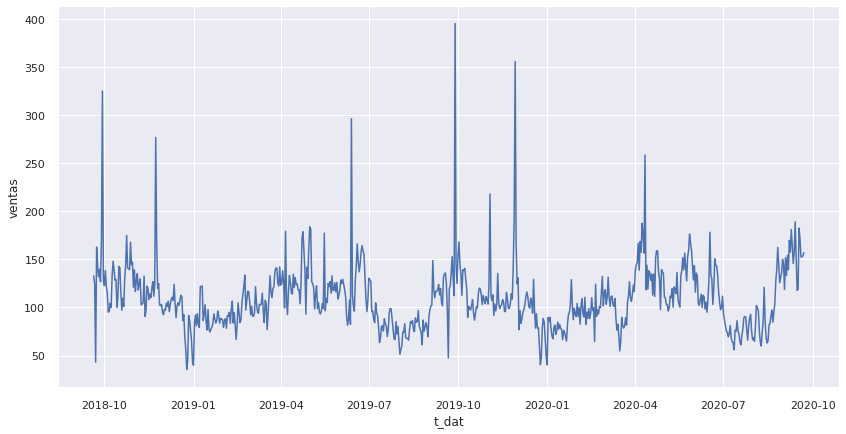

In [90]:
aux5cluster5 = aux5[aux5['Cluster']==5]
fig, ax = plt.subplots(figsize=(14,7))

# multiple line plots
sns.lineplot(data=aux5cluster5, x='t_dat', y='ventas')

# show graph
plt.show()

In [ ]:
cluster_profile = df.groupby('K_means_segments').mean()

In [ ]:
# Obtenemos las etiquetas de cada punto de nuestros datos
labels = kmeans.predict(X)
# Obtenemos los centroids
C = kmeans.cluster_centers_
colores=['red','green','blue','cyan','yellow']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

In [ ]:
#articles['article_id'] = articles['article_id'].astype(str)
articles['index_group_no'] = articles['index_group_no'].astype(str)
#transactions['article_id'] = transactions['article_id'].astype(str)

In [ ]:
temp = pd.merge(transactions[["customer_id", "article_id"]], articles[['article_id','index_group_no']], on="article_id", how='inner')

# check null values and drop it.
display(temp[temp.isnull().any(axis=1)])

temp = temp.dropna()

ca_matrix = pd.crosstab(index=temp.customer_id, columns=temp.index_group_no)
ca_matrix

In [ ]:
temp

In [ ]:
temp.dtypes

In [ ]:
transactions = transactions[["customer_id", "article_id", "price"]]
customers = customers[["customer_id", "age"]]
articles = articles[["article_id", "prod_name", "product_type_name", "product_group_name",
                     "department_name", "index_name", "index_group_name",
                     "section_name", "garment_group_name"]]



In [ ]:
temp = pd.merge(transactions, articles, on="article_id", how='inner')
temp = pd.merge(temp, customers, on="customer_id", how='inner')
temp